In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from HPA_CC.models.train import find_checkpoint_file, PseudoRegressorLit, ClassifierLit, CombinedModelLit
from HPA_CC.models.utils import regressor_inference, classifier_inference, combined_inference
from HPA_CC.data.data_viz import save_image, annotate_cell_image
from HPA_CC.utils.img_tools import get_batch_percentiles
from HPA_CC.data.well_normalization import buckets
from HPA_CC.utils.pseudotime import stretch_time
from HPA_CC.data.dataset import RefCLSDM

from config import HOME, HPA_DS_PATH, FUCCI_DS_PATH
classes = ["M-G1", "G1", "S-G2", "G2"]
protein = "CCNB1"
data_name = "minimal"

/tmp/ipykernel_3607428/3421727259.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(HOME / 'data' / 'ifimages_v23.csv')
print(df.columns)
df.head()

Index(['filename', 'jpg_prefix', 'if_plate_id', 'position', 'sample', 'status',
       'Image status name', 'locations', 'staining characteristics',
       'unspecific', 'antibody', 'ensembl_ids', 'gene_names', 'atlas_name',
       'versions', 'earliest_version', 'first_released', 'latest_version',
       'Spatial cell cycle', 'Intensity cell cycle', 'Annotated cell cycle',
       'gain', 'x_pos', 'y_pos', 'z_pos', 'Experiment state', 'Ab state',
       'Max tpm', 'Finished in genes', 'Protocol',
       'Gene reliability (in release)', 'Gene reliability (lims)',
       'Cell count', 'well_location_predictions_all'],
      dtype='object')


,filename,jpg_prefix,if_plate_id,position,sample,status,Image status name,locations,staining characteristics,unspecific,...,z_pos,Experiment state,Ab state,Max tpm,Finished in genes,Protocol,Gene reliability (in release),Gene reliability (lims),Cell count,well_location_predictions_all
0,/archive/1/1_A1_1_,https://lims.proteinatlas.org/images/992/1_A1_1_,1,A1,1,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,7.0,NaN
1,/archive/1/1_A1_2_,https://lims.proteinatlas.org/images/992/1_A1_2_,1,A1,2,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,6.0,NaN
2,/archive/1/1_A3_1_,https://lims.proteinatlas.org/images/2899/1_A3_1_,1,A3,1,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,4.0,NaN
3,/archive/1/1_A3_2_,https://lims.proteinatlas.org/images/2899/1_A3_2_,1,A3,2,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,6.0,NaN
4,/archive/1/1_A6_1_,https://lims.proteinatlas.org/images/609/1_A6_1_,1,A6,1,35,Annotated / Proteinatlas,"Endoplasmic reticulum,Nuclear membrane",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,81.38,ENSG00000102119,PFA,Enhanced,Enhanced,5.0,NaN


In [3]:
print(df[["filename", "antibody", "gene_names"]].values[0])

['/archive/1/1_A1_1_' 'HPA000992' 'GOLGA5']


In [4]:
def prefix_to_well(filename):
    image_id = filename.split('/')[-1]
    return '_'.join(image_id.split('_')[:2])

df["well"] = df["filename"].apply(prefix_to_well)
print(df["well"].values)

['1_A1' '1_A1' '1_A3' ... '2172_F7' '2172_H8' '2172_H8']


In [5]:
CCD_prots = ["DUSP19", "DUSP18", "PAPSS1", "N6AMT1", "PHLDB1", "FLI1", "TTC21B", "PC", "UGDH", 
             "ORC6", "ZNF32", "CCNE1", "CCNB1", "AURKB", "BUB1B", "DPH2", "GMNN", "CDT1", "ANLN"]
ccd_rows = df["gene_names"].isin(CCD_prots) & df["atlas_name"].isin(["U2OS"])
ccd_df = df[ccd_rows]
print(ccd_df["filename"].values[0])
print(ccd_df[["well", "antibody", "gene_names"]].values[0])

/archive/91/91_H6_1_
['91_H6' 'HPA008419' 'BUB1B']


# Setup and Data Prep

In [6]:
# Pick a protein
DS_HOME = HPA_DS_PATH
# DS_HOME = FUCCI_DS_PATH
prot_well_names = ccd_df[ccd_df["gene_names"] == protein]["well"].unique()
prot_abs = ccd_df[ccd_df["gene_names"] == protein]["antibody"].unique()
print(prot_well_names)
print(prot_abs)
# prot_well_names = ["chamber--U01--V00"]

['663_E2' '845_A6' '1671_B6']
['CAB000115' 'HPA030741' 'HPA061448']


[9, 7, 8, 6, 13, 8]


<Figure size 640x480 with 0 Axes>

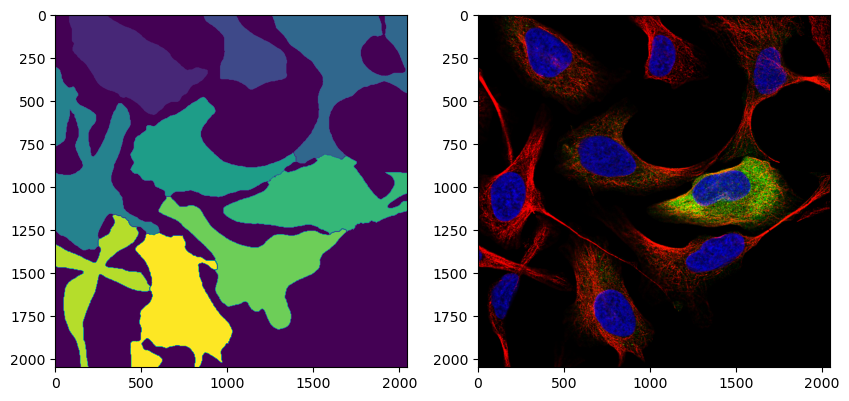

<Figure size 640x480 with 0 Axes>

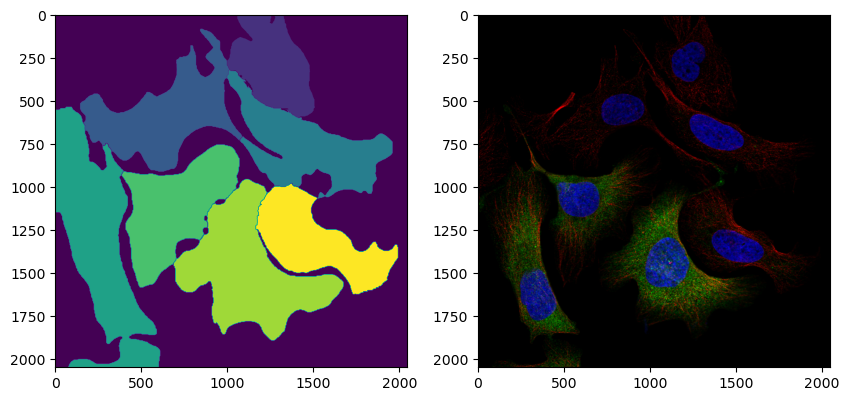

<Figure size 640x480 with 0 Axes>

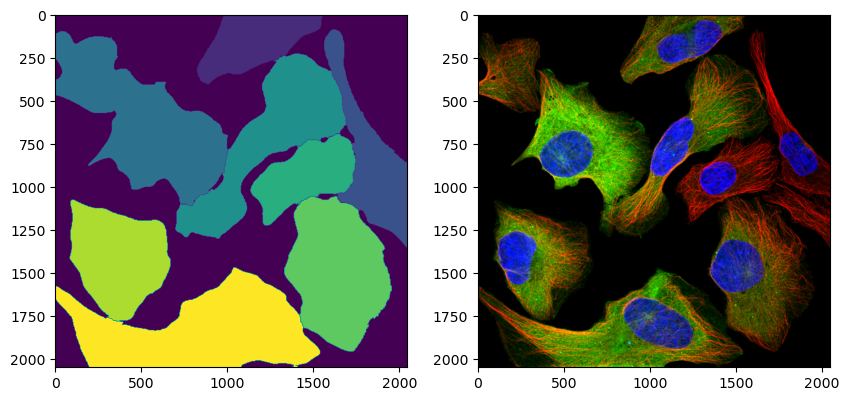

<Figure size 640x480 with 0 Axes>

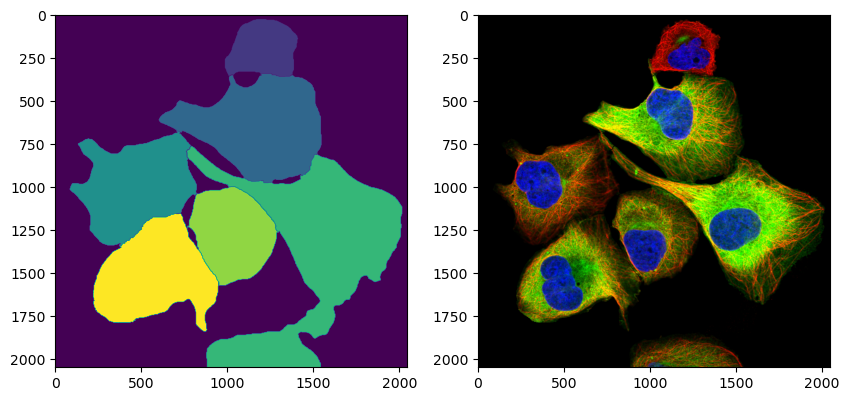

<Figure size 640x480 with 0 Axes>

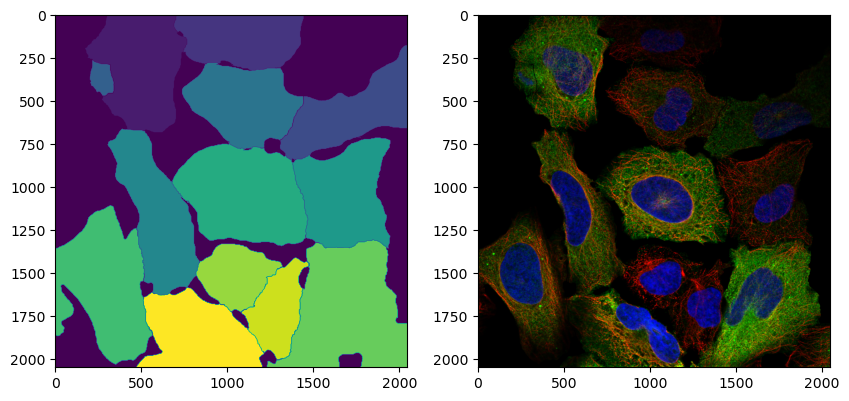

<Figure size 640x480 with 0 Axes>

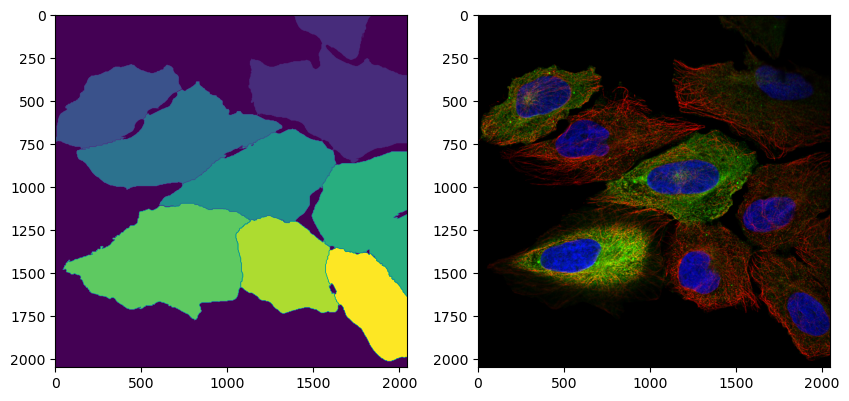

In [7]:
# prep data needed for model inference and visualization

image_paths = []
cell_mask_paths = []
for well in prot_well_names:
    # should really get these from the dataset config
    image_paths.append(DS_HOME / well / f"imagesmin_max.npy")
    cell_mask_paths.append(DS_HOME / well / f"cell_masks_no_border_rm_1000_sharp_none.npy")
    # cell_mask_paths.append(DS_HOME / well / f"cell_masks_no_border_rm_1000_sharp_1250.npy")

images = np.concatenate([np.load(p) for p in image_paths])

masks = [np.load(p) for p in cell_mask_paths]
n_per_image = np.array([[len(np.unique(m)) - 1 for m in mask_list] for mask_list in masks]).flatten().tolist()
print(n_per_image)
masks = np.concatenate(masks)

ref_images = images[:, :2, ...]
color_images = [save_image(torch.Tensor(I[[0, 1, 3]]), HOME / "temp.png", cmaps=["pure_blue", "pure_red", "pure_green"]) for I in images]
# color_images = [save_image(torch.Tensor(I), HOME / "temp.png", cmaps=["pure_blue", "pure_yellow", "pure_green", "pure_red"]) for I in images]

for i in range(len(color_images)):
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(masks[i])
    ax[1].imshow(color_images[i])
    plt.show()

sc_images = torch.concat([torch.load(DS_HOME / well / "images_minimal.pt") for well in prot_well_names])
assert len(sc_images) == sum([len(np.unique(m)) - 1 for m in masks])

In [8]:
# get well percentiles
percentiles = np.linspace(0, 100, buckets)
# n, j, k = 0, 0, 0
j, k = 0, 0
image_intensities = []
n_cells_per_well = []
for i, image in enumerate(ref_images):
    int_levels, _ = get_batch_percentiles(image[None, ...], percentiles)
    int_levels = np.concatenate(int_levels)
    image_intensities.append(np.tile(int_levels, (n_per_image[i], 1)))
    j = k
image_intensities = torch.Tensor(np.concatenate(image_intensities))
print(image_intensities.shape)

torch.Size([51, 512])


In [9]:
from HPA_CC.models.dino import DINO_HPA
from torch.utils.data import DataLoader
from HPA_CC.data.dataset import SimpleDataset


device = "cuda:0"
DINO_CONFIG = HOME / "configs" / "dino_config.yaml"
dino = DINO_HPA(DINO_CONFIG, device=device)
dataset = SimpleDataset(tensor=sc_images[:, :2, ...])
dataloader = DataLoader(dataset, batch_size=32, num_workers=1, shuffle=False)
embeddings = []
with torch.no_grad():
    for batch in iter(dataloader):
        batch = batch.to(device)
        batch_embedding = dino.predict_cls_ref_concat(batch).cpu()
        embeddings.append(batch_embedding)
embeddings = torch.cat(embeddings)
print(embeddings.shape)

config['model']['arch'] vit_base in vits


loaded /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth
Pretrained weights found at /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181081/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([51, 1536])


# Model Inference

In [10]:
log_dirs_home = Path("/data/ishang/pseudotime_pred/")
device = "cuda:0"

/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


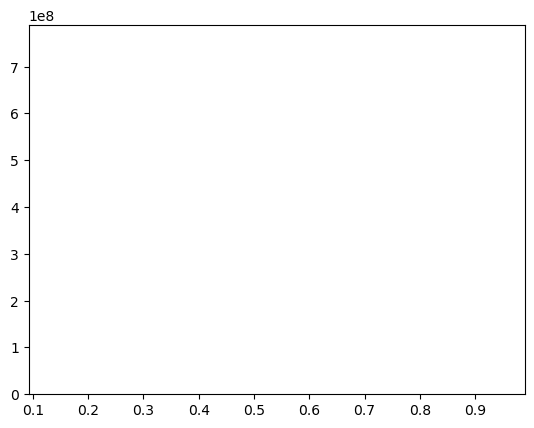

In [11]:
model_name = "HPA DINO Multi-model"
model_hash = "zb99ws39" # hard with dropout, without intensity stats
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = False # were intensity statistics added to the embedding? (not used from conv)
scope = True
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
combined_model = CombinedModelLit.load_from_checkpoint(checkpoint_file)
combined_model.to(device)
combined_model.eval()
input = torch.concat([embeddings, image_intensities], dim=1) if int_stats else embeddings
prot_pseudo_dataset = SimpleDataset(tensor=input)
pseudo_preds, angle_preds, phase_preds = combined_inference(combined_model, DataLoader(prot_pseudo_dataset, batch_size=32, num_workers=1, shuffle=False), device)
pseudo_preds = stretch_time(angle_preds)

# Annotated Images

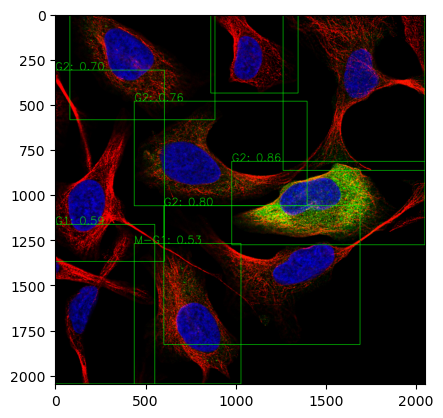

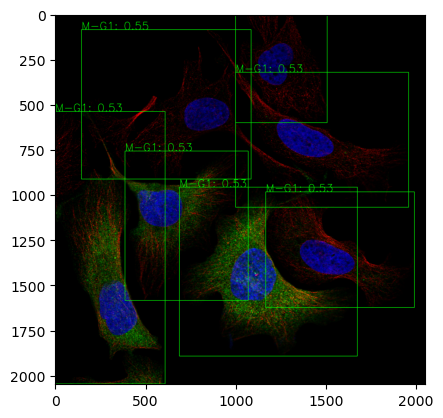

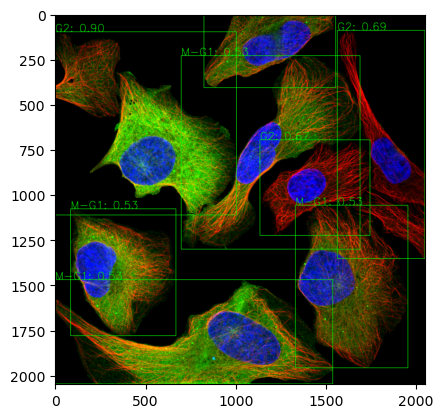

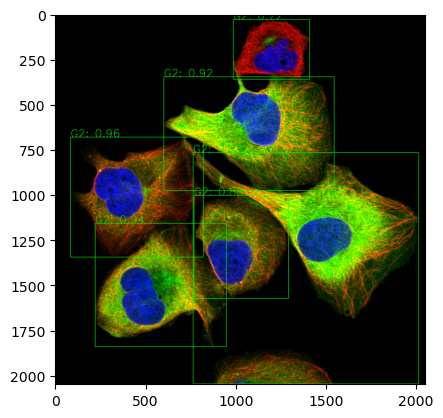

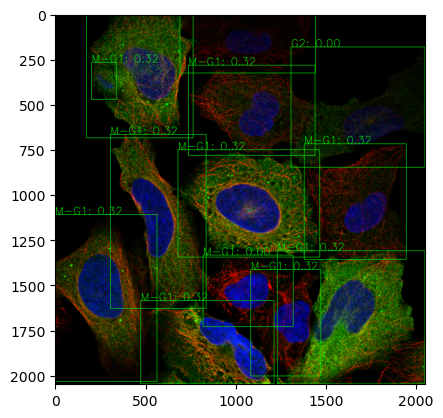

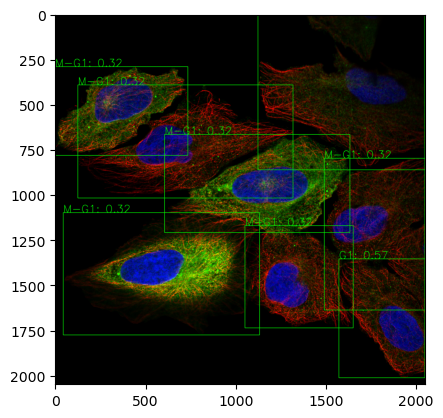

In [14]:
cell_idx = 0
for image, mask in zip(color_images, masks):
# for image, mask in zip(ref_images, masks):
    n_cells = len(np.unique(mask)) - 1
    pseudotimes = pseudo_preds[cell_idx:cell_idx + n_cells]
    phases = phase_preds[cell_idx:cell_idx + n_cells]
    pseudotimes = np.round(pseudotimes, 2)
    phases = [classes[p] for p in phases]
    image = np.array(image)
    # if len(image) < 3:
    #     image = np.concatenate([image, np.zeros_like(image[0])[None, ...]])
    annotated_image = annotate_cell_image(image, mask, pseudotimes, phases)
    cell_idx += n_cells
    plt.clf()
    plt.imshow(annotated_image)
    plt.show()

# HPA Prediction Histograms

In [16]:
full_datamodule = RefCLSDM(HPA_DS_PATH, data_name, 32, 1, "all", inference=True, concat_well_stats=False)
pseudo_preds, angle_preds, phase_preds = combined_inference(combined_model, full_datamodule.inference_dataloader(), device)

Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
X shape: torch.Size([1870, 1536])


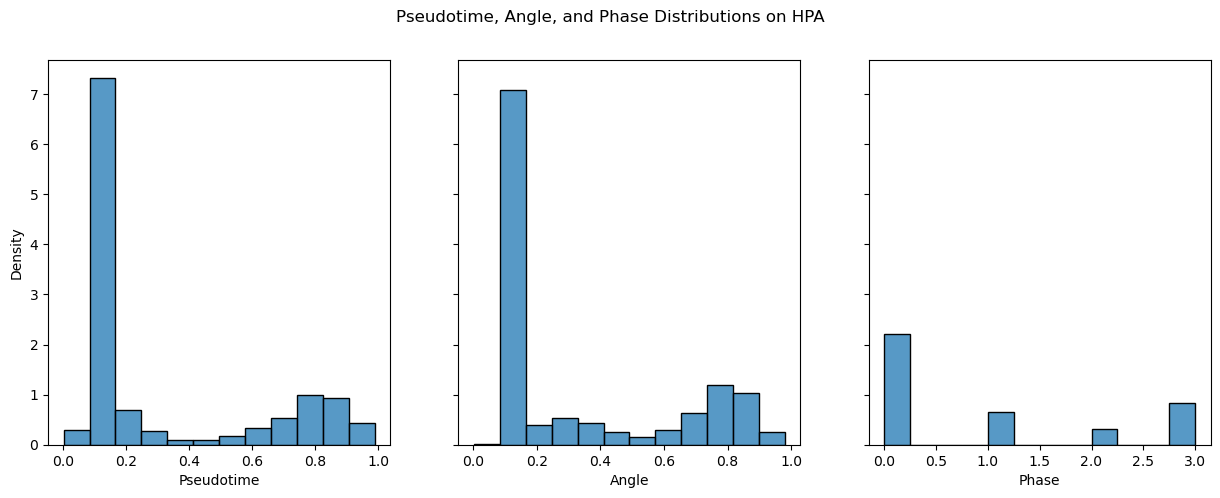

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.histplot(pseudo_preds, ax=ax[0], stat="density")
sns.histplot(angle_preds, ax=ax[1], stat="density")
sns.histplot(phase_preds, ax=ax[2], stat="density")
ax[0].set_xlabel("Pseudotime")
ax[1].set_xlabel("Angle")
ax[2].set_xlabel("Phase")
plt.ylabel("Density")
fig.suptitle("Pseudotime, Angle, and Phase Distributions on HPA")
plt.show()